In [1]:
import torch
import argparse
import soundfile as sf
from torchmetrics import MetricCollection, Recall, Accuracy, Precision, AveragePrecision

from clara import PLCLARA
from datamodule.utils import get_log_melspec
from eval.util import get_dataset
from eval.test_zeroshot import run as zeroshot_run
from eval.test_zeroshot import zeroshot_classifier

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/admin/home-knoriy/miniconda3/envs/clasp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/admin/home-knoriy/miniconda3/envs/clasp/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
waveform, sr = sf.read('/fsx/knoriy/CLASP/clasp/demo/hello_world.mp3')
mels = get_log_melspec(waveform, sr)

In [21]:
templates = ['hello world', '10 am', 'tuesday', 'goodbye']

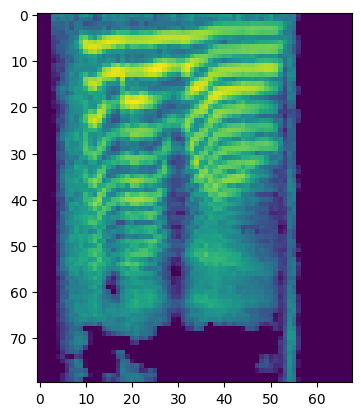

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(mels.T.numpy())

In [52]:
parser = argparse.ArgumentParser()
parser.add_argument('--model_path', type=str, help='Path to model')
parser.add_argument('--task', type=str, choices=['texts', 'gender', 'emotion', 'age', 'sounds', 'speech'], help='Task to run')
parser.add_argument('--dataset_name', type=str, required=True, help='if task is sounds or emotion, specify dataset name')
parser.add_argument('--root_cfg_path', type=str, default='./config/', help='root path to config files')
parser.add_argument('--top_k', type=int, default=[1,5,10], help='Top k metrics to use')
parser.add_argument('--batch_size', type=int, default=8, help='Dataloader batch size')
parser.add_argument('--num_workers', type=int, default=12, help='Dataloader number of workers')

args = parser.parse_args(
    '--model_path /fsx/knoriy/CLASP/logs/CLASP/Emotion_datasets_76acc_42epoch_60M/checkpoints/epoch=41-step=3402.ckpt --task emotion --dataset_name emov-db --root_cfg_path ../config/'.split()
)

In [53]:
##############
# Model
##############
model = PLCLARA.load_from_checkpoint(args.model_path, map_location=device)

In [54]:
##############
# DataModule
##############

dataset, templates, classes = get_dataset(
    task = args.task, 
    dataset_name = args.dataset_name, 
    root_cfg_path = args.root_cfg_path, 
    batch_size = args.batch_size, 
    num_workers = args.num_workers
)

Creating Url list
Creating URL cache: logs/EmoV_DB.json
Urls found: 			
	Train: 10 			
	Valid: 2 			
	Test: 3


In [55]:
print(templates, classes)

['a person talking in a {} voice'] {'angry': 0, 'disgusted': 1, 'amused': 2, 'sleepy': 3, 'neutral': 4}


In [56]:
##############
# Metric
##############
num_classes = len(classes)
metric = MetricCollection({})

for top_k in args.top_k:
    if top_k > num_classes:
        break
    metric.add_metrics({
        f"acc@{top_k}":Accuracy(task='multiclass', num_classes=num_classes, top_k=top_k),
        })

##############
# Run
##############
dataset.setup()

zeroshot_weights, all_texts = zeroshot_classifier(model, classes, templates)
tops = zeroshot_run(model, zeroshot_weights, dataset.test_dataloader(), metric, args.task, limit_batches=1)
tops


MiniBatch: 1it [00:08,  8.73s/it]


{'avg_acc@1': tensor(0.5625), 'avg_acc@5': tensor(1.)}

In [57]:
tops

{'avg_acc@1': tensor(0.5625), 'avg_acc@5': tensor(1.)}

In [15]:
import sys
import os

import tqdm
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.nn import functional as F

from torchmetrics import MetricCollection, Recall, Accuracy, Precision, AveragePrecision

from clasp import PLCLASP
from text.tokeniser import Tokeniser
from utils import calculate_average
from eval.util import get_dataset

##############
# Non Critical imports
##############
from pprint import pprint

def run(model, zeroshot_weights, dataloader, metric_fn:MetricCollection, task:str, limit_batches=-1):
	device = model.device
	model.eval()
	with torch.no_grad():
		metrics = []

		metric_fn = metric_fn.to(device)

		for i, batch in enumerate(tqdm.tqdm(dataloader, desc='MiniBatch')):
			labels, mels, _, _ = batch
			labels = labels['texts'].to(device)
			mels = mels.to(device)

			###############
			# Get Temps
			###############
			text_temp, audio_temp = model.get_temps()

			###############
			# Audio Features
			###############
			audio_features = model.encode_audio(mels)
			audio_features = model.model.audio_transform(audio_features)
			audio_features = F.normalize(audio_features, dim=-1)

			###############
			# Text Features
			###############
			text_features = model.encode_text(labels)
			text_features = model.model.text_transform(text_features)
			text_features = F.normalize(text_features, dim=-1)

			logits_per_audio = (audio_temp * (audio_features @ text_features.T))
			labels = torch.eye(logits_per_audio.size(0)).to(device)

		# 	###############
		# 	# Get metrics
		# 	###############
			metric = metric_fn(logits_per_audio, labels)
			metrics.append(metric)
			if i == limit_batches:
				break

		avg_metric = calculate_average(metrics)

	return avg_metric

In [18]:
def main(args):
	##############
	# Model
	##############
	model = PLCLASP.load_from_checkpoint(args.model_path).to(device)

	##############
	# DataModule
	##############

	dataset, templates, classes = get_dataset(
		task = args.task, 
		dataset_name = args.dataset_name, 
		root_cfg_path = args.root_cfg_path, 
		batch_size = args.batch_size, 
		num_workers = args.num_workers
	)

	##############
	# Metric
	##############
	# num_classes = len(classes)
	metric = MetricCollection({})

	# for top_k in args.top_k:
	# 	if top_k > num_classes:
	# 		break
	# 	metric.add_metrics({
	# 		f"rec@{top_k}":Recall(task='multiclass', num_classes=num_classes, top_k=top_k),
	# 		f"acc@{top_k}":Accuracy(task='multiclass', num_classes=num_classes, top_k=top_k),
	# 		f"pre@{top_k}":Precision(task='multiclass', num_classes=num_classes, top_k=top_k),
	# 		})

	# metric.add_metrics({f"AP":AveragePrecision(task='multiclass', num_classes=num_classes)})

	metric.add_metrics({f"acc@{1}":Accuracy(task='binary')})

	##############
	# Run
	##############
	dataset.setup()

	zeroshot_weights, all_texts = zeroshot_classifier(model, classes, templates)
	tops = run(model, zeroshot_weights, dataset.test_dataloader(), metric, args.task)

	return tops

if __name__ == '__main__':
	import argparse
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

	parser = argparse.ArgumentParser()
	parser.add_argument('--model_path', type=str, help='Path to model')
	parser.add_argument('--task', type=str, choices=['texts', 'gender', 'emotion', 'age', 'sounds', 'speech'], help='Task to run')
	parser.add_argument('--dataset_name', type=str, required=True, help='if task is sounds or emotion, specify dataset name')
	parser.add_argument('--root_cfg_path', type=str, default='./config/', help='root path to config files')
	parser.add_argument('--top_k', type=int, default=[1,5,10], help='Top k metrics to use')
	parser.add_argument('--batch_size', type=int, default=8, help='Dataloader batch size')
	parser.add_argument('--num_workers', type=int, default=12, help='Dataloader number of workers')

	args = parser.parse_args(
        '--model_path ../logs/CLASP/US8K_77acc_57epoch_100M/checkpoints/epoch=57-step=15196.ckpt --task sounds --dataset_name us8k --root_cfg_path ../config/'.split()
    )

	tops = main(args)

	pprint(tops)

Creating Url list
Creating URL cache: logs/Urbansound8K.json
Urls found: 			
	Train: 14 			
	Valid: 2 			
	Test: 2
MiniBatch: 110it [00:10, 10.10it/s]

{'avg_acc@1': tensor(0.5382, device='cuda:0')}


In [12]:
acc_fn = Accuracy(task='binary').to(device)

In [13]:
acc_fn(*tops)

tensor(0.5625, device='cuda:0')